In [4]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

The data from Byrne et al 2021 https://ui.adsabs.harvard.edu/abs/2022MNRAS.510.2011B/abstract is available on the journal's web page https://academic.oup.com/mnras/article/510/2/2011/6426199 in healfits and skyh5 files.

skyh5 is https://github.com/RadioAstronomySoftwareGroup/pyradiosky which needs to be installed

The healfits format seems a little nonstandard, at least according to astropy:
https://astropy-healpix.readthedocs.io/en/latest/interpolation.html
but it pretty clearly contains maps for the 4 Stokes parameters at NSIDE=512 at the indices given in the table in the second extension.

In [3]:
path = '/lustre/aoc/projects/hera/jaguirre/SkyModels/'

In [10]:
difmap = fits.open(path+'diffuse_map.healfits')

In [11]:
difmap.info()

Filename: /lustre/aoc/projects/hera/jaguirre/SkyModels/diffuse_map.healfits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (4, 1, 831822)   float64   
  1  HPX_INDS      1 BinTableHDU     11   831822R x 1C   [K]   


In [12]:
difmap[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                    4                                                  
NAXIS2  =                    1                                                  
NAXIS3  =               831822                                                  
EXTEND  =                    T                                                  
NSIDE   =                  512                                                  
ORDERING= 'nested  '                                                            
BUNIT   = 'Jy/sr   '                                                            
COORDSYS= 'C       '                                                            
AUTHOR  = 'Ruby Byrne'                                                          
INSTRUME= 'MWA     '        

In [53]:
ordering = difmap[0].header['ORDERING']
nside = difmap[0].header['NSIDE']
npix = hp.nside2npix(nside)

In [45]:
difmap[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    8 / length of dimension 1                          
NAXIS2  =               831822 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'HPX_INDS'                                                            
TFORM1  = 'K       '                                                            
EXTNAME = 'HPX_INDS'                                                            

In [49]:
hpx_inds_bintable = difmap[1].data
n_inds = len(hpx_inds)
hpx_inds = np.zeros(n_inds, dtype='int64')

In [50]:
%%time
# by default, hpx_inds_bintable is a pretty unwieldy structure: a list of tuples
for i, hpx_ind in enumerate(hpx_inds_bintable):
    #print(i, hpx_ind[0])
    hpx_inds[i] = hpx_ind[0]

CPU times: user 27.1 s, sys: 446 µs, total: 27.1 s
Wall time: 27.2 s


In [78]:
hp.reorder?

In [79]:
stokes = ['I', 'Q', 'U', 'V']
ring_inds = hp.nest2ring(nside, hpx_inds)
maps = {}
for i, stoke in enumerate(stokes):
    maps[stoke] = np.zeros(npix)
    maps[stoke][ring_inds] = difmap[0].data[:,0,i]

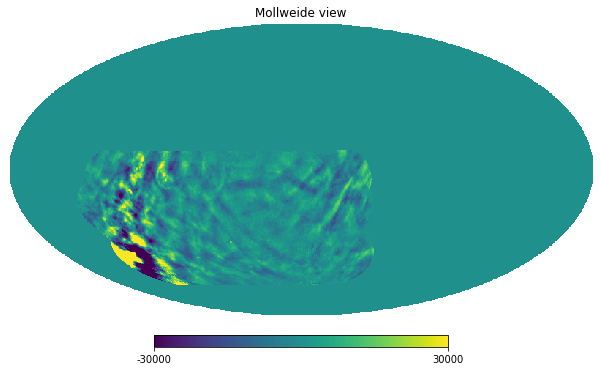

In [99]:
hp.mollview(maps['I'], min=-3e4, max=3e4)

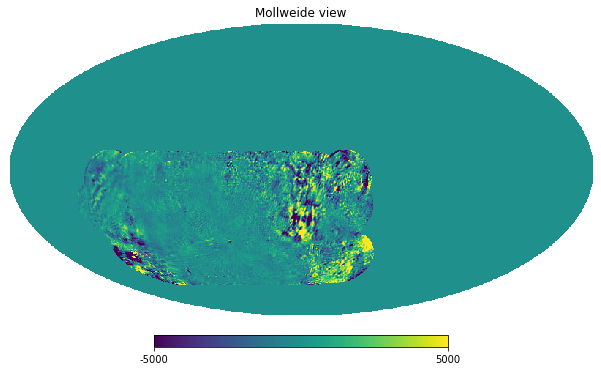

In [81]:
hp.mollview(maps['Q'], min=-5e3, max=5e3)

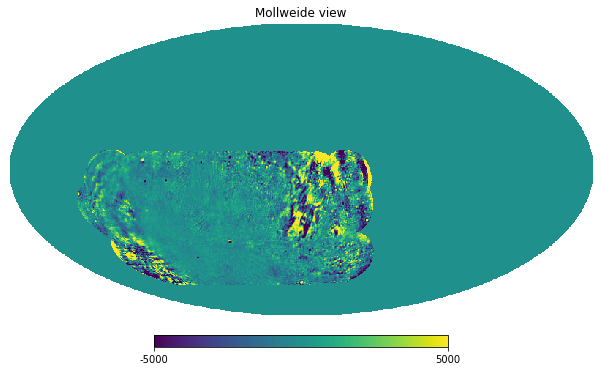

In [82]:
hp.mollview(maps['U'], min=-5e3, max=5e3)

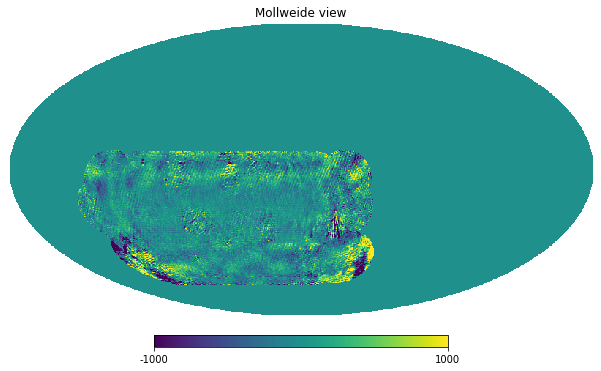

In [83]:
hp.mollview(maps['V'], min=-1e3, max=1e3)

In [73]:
hp.anafast?

In [85]:
%%time
# Note that it's not correct to transform Q and U as spin-0 fields; just trying to get a sense of the support in ell-space, 
# which is probably complicated by the windowing ...
Cl = {}
for stoke in stokes:
    Cl[stoke] = hp.anafast(maps[stoke])

CPU times: user 21.2 s, sys: 103 ms, total: 21.3 s
Wall time: 21.3 s


In [88]:
ell = np.arange(len(Cl['I']))

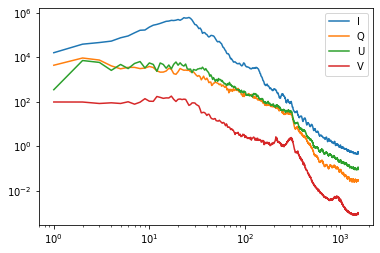

In [89]:
for stoke in stokes:
    plt.loglog(ell[1:], Cl[stoke][1:], label=stoke)
plt.legend()